In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import xgboost

In [2]:
trainset = pd.read_csv("./train.csv")
testset = pd.read_csv("./test.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

In [3]:
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number


def preprocessing(data):
    data = data.copy()
    
    # 날짜 형식에 대해 데이터타입 적용
    data.Date = pd.to_datetime(data.Date, format="%d/%m/%Y")
    
    # 날짜 데이터를 주, 일, 월 달 로 분리
    data['Week'] = data.Date.dt.isocalendar().week.apply(lambda x: int(x))
    data['Day'] = data.Date.dt.day.apply(lambda x: int(x))
    data['Year'] = data.Date.dt.year.apply(lambda x: int(x))
    data['Month'] = data.Date.dt.month.apply(lambda x: int(x))
    
    # True/False => 1/0
    data['NumberHoliday'] = data['IsHoliday'].apply(holiday_to_number)
    
    return data

In [4]:
# 데이터 전처리
trainset = preprocessing(trainset)
testset = preprocessing(testset)

**연도별 매출 추이**

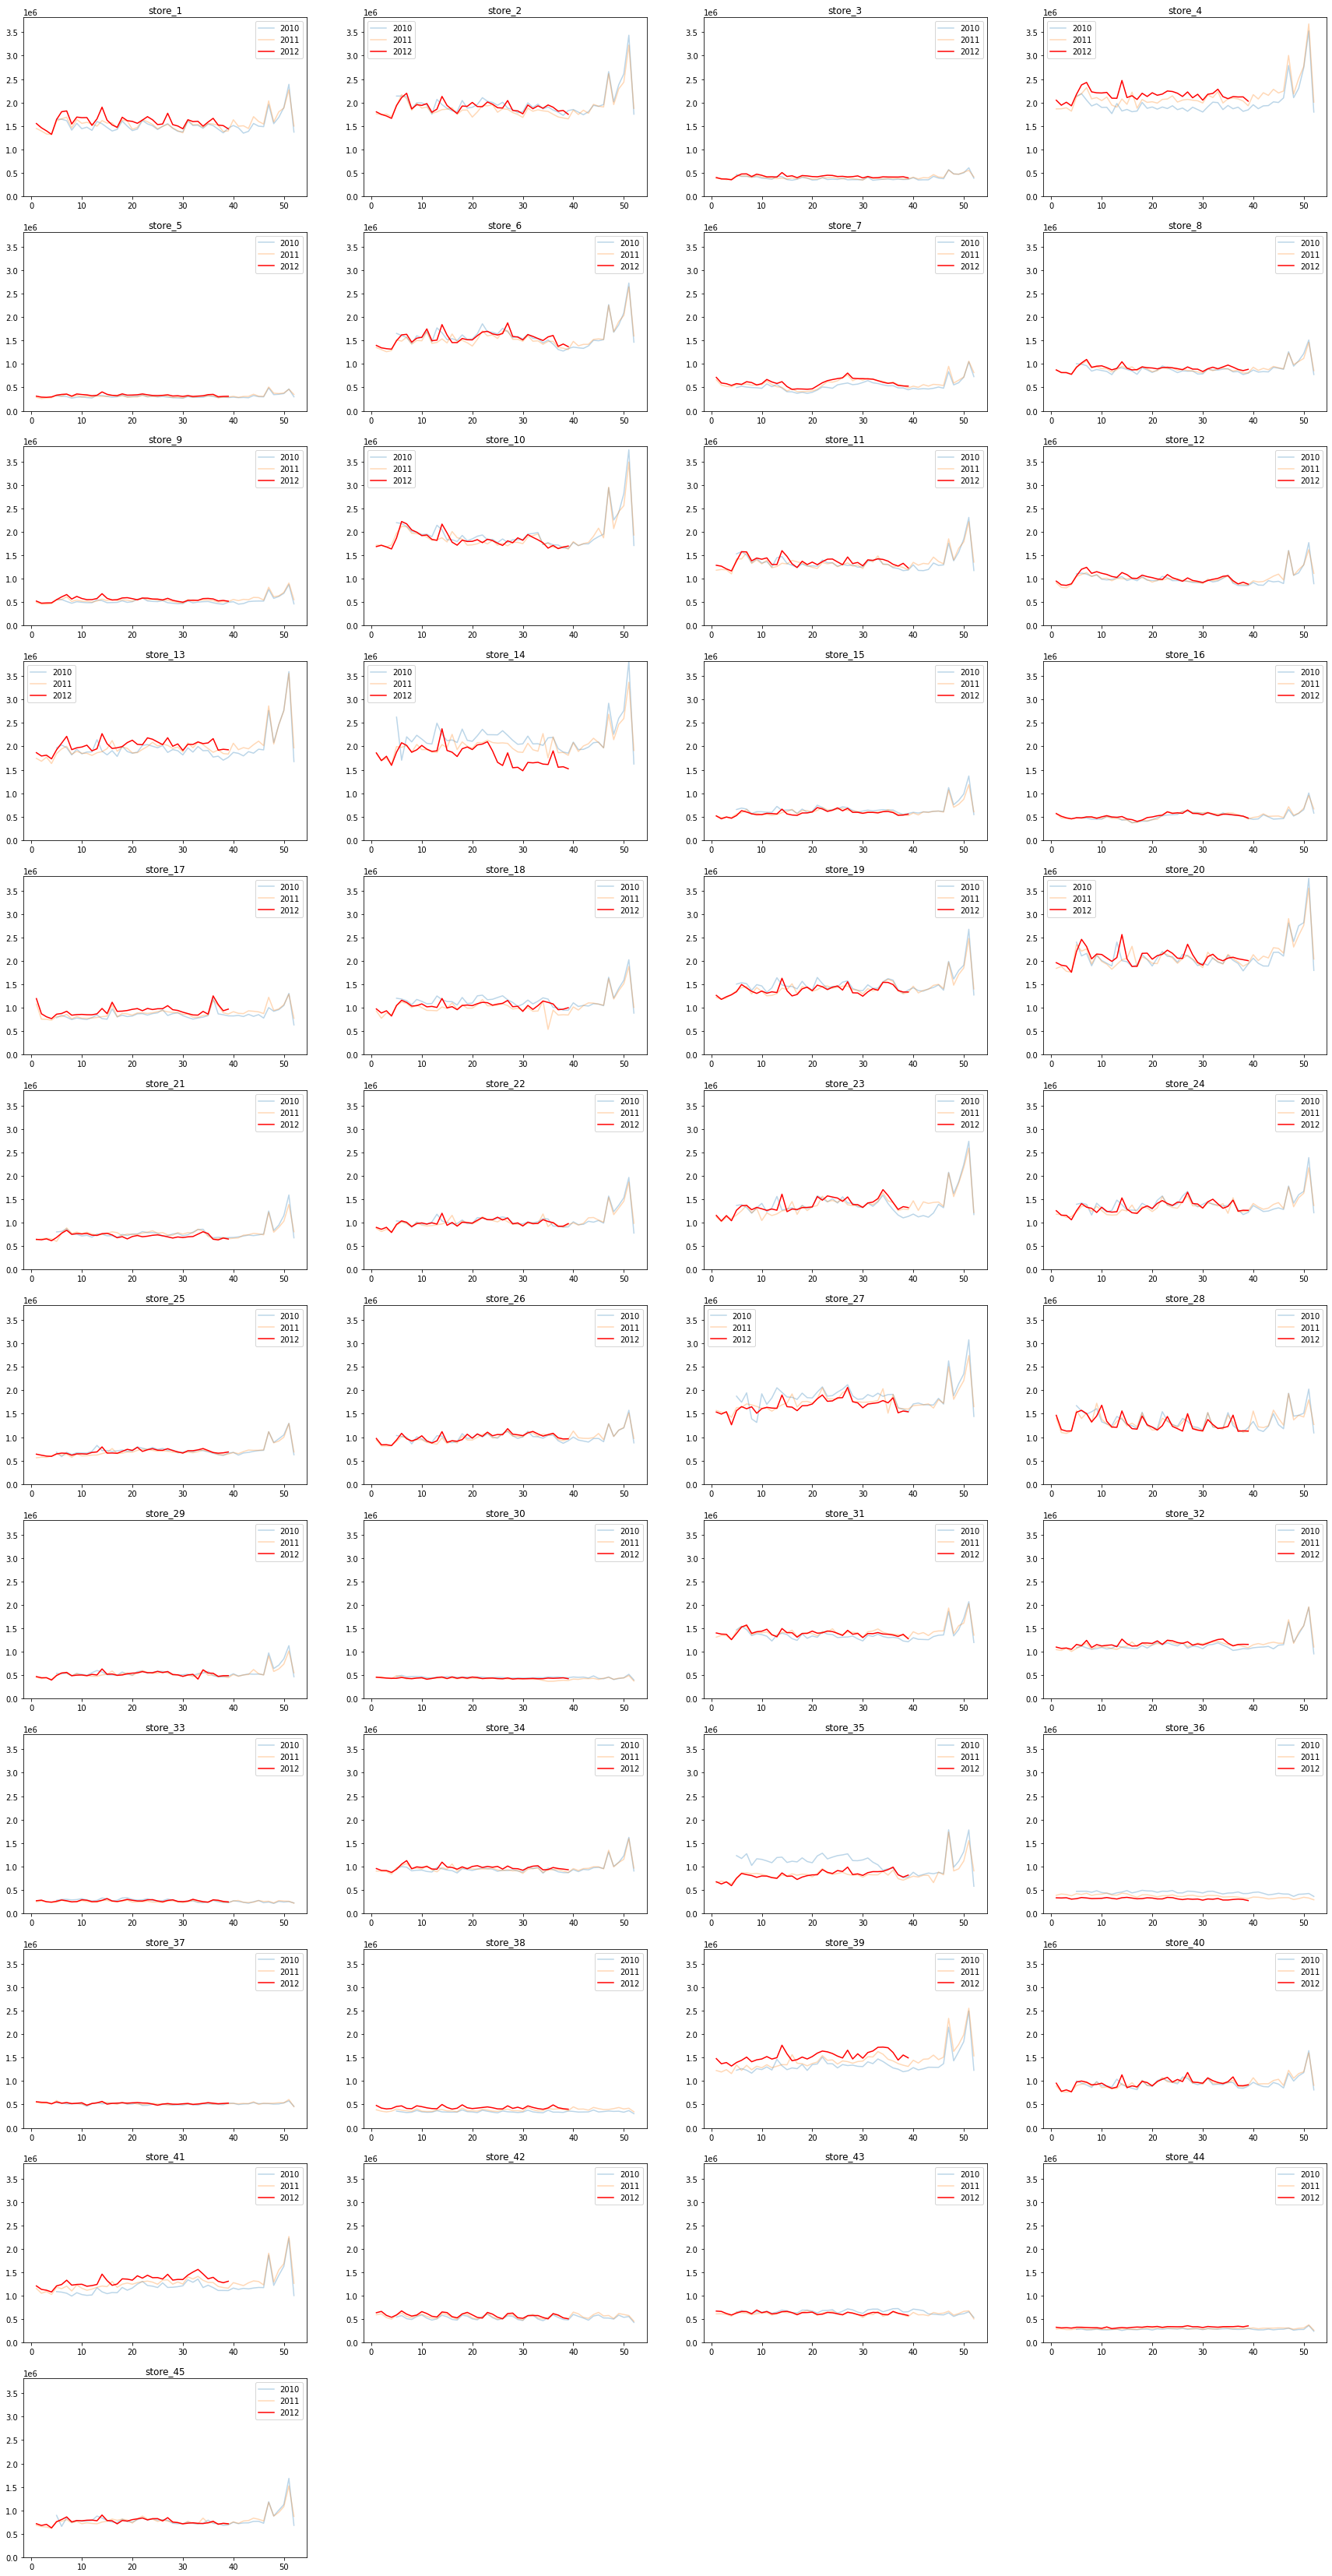

In [5]:
max_sales = max(trainset.Weekly_Sales)

fig = plt.figure(figsize=(30,60))

for store in range(1,max(trainset.Store)+1):
    storeset = trainset[trainset.Store==store]
    storeset_2010 = storeset[storeset.Year==2010]
    storeset_2011 = storeset[storeset.Year==2011]
    storeset_2012 = storeset[storeset.Year==2012]
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.legend()
    plt.ylim(0, max_sales)
    
plt.show()

**지점별 매출액 차이**

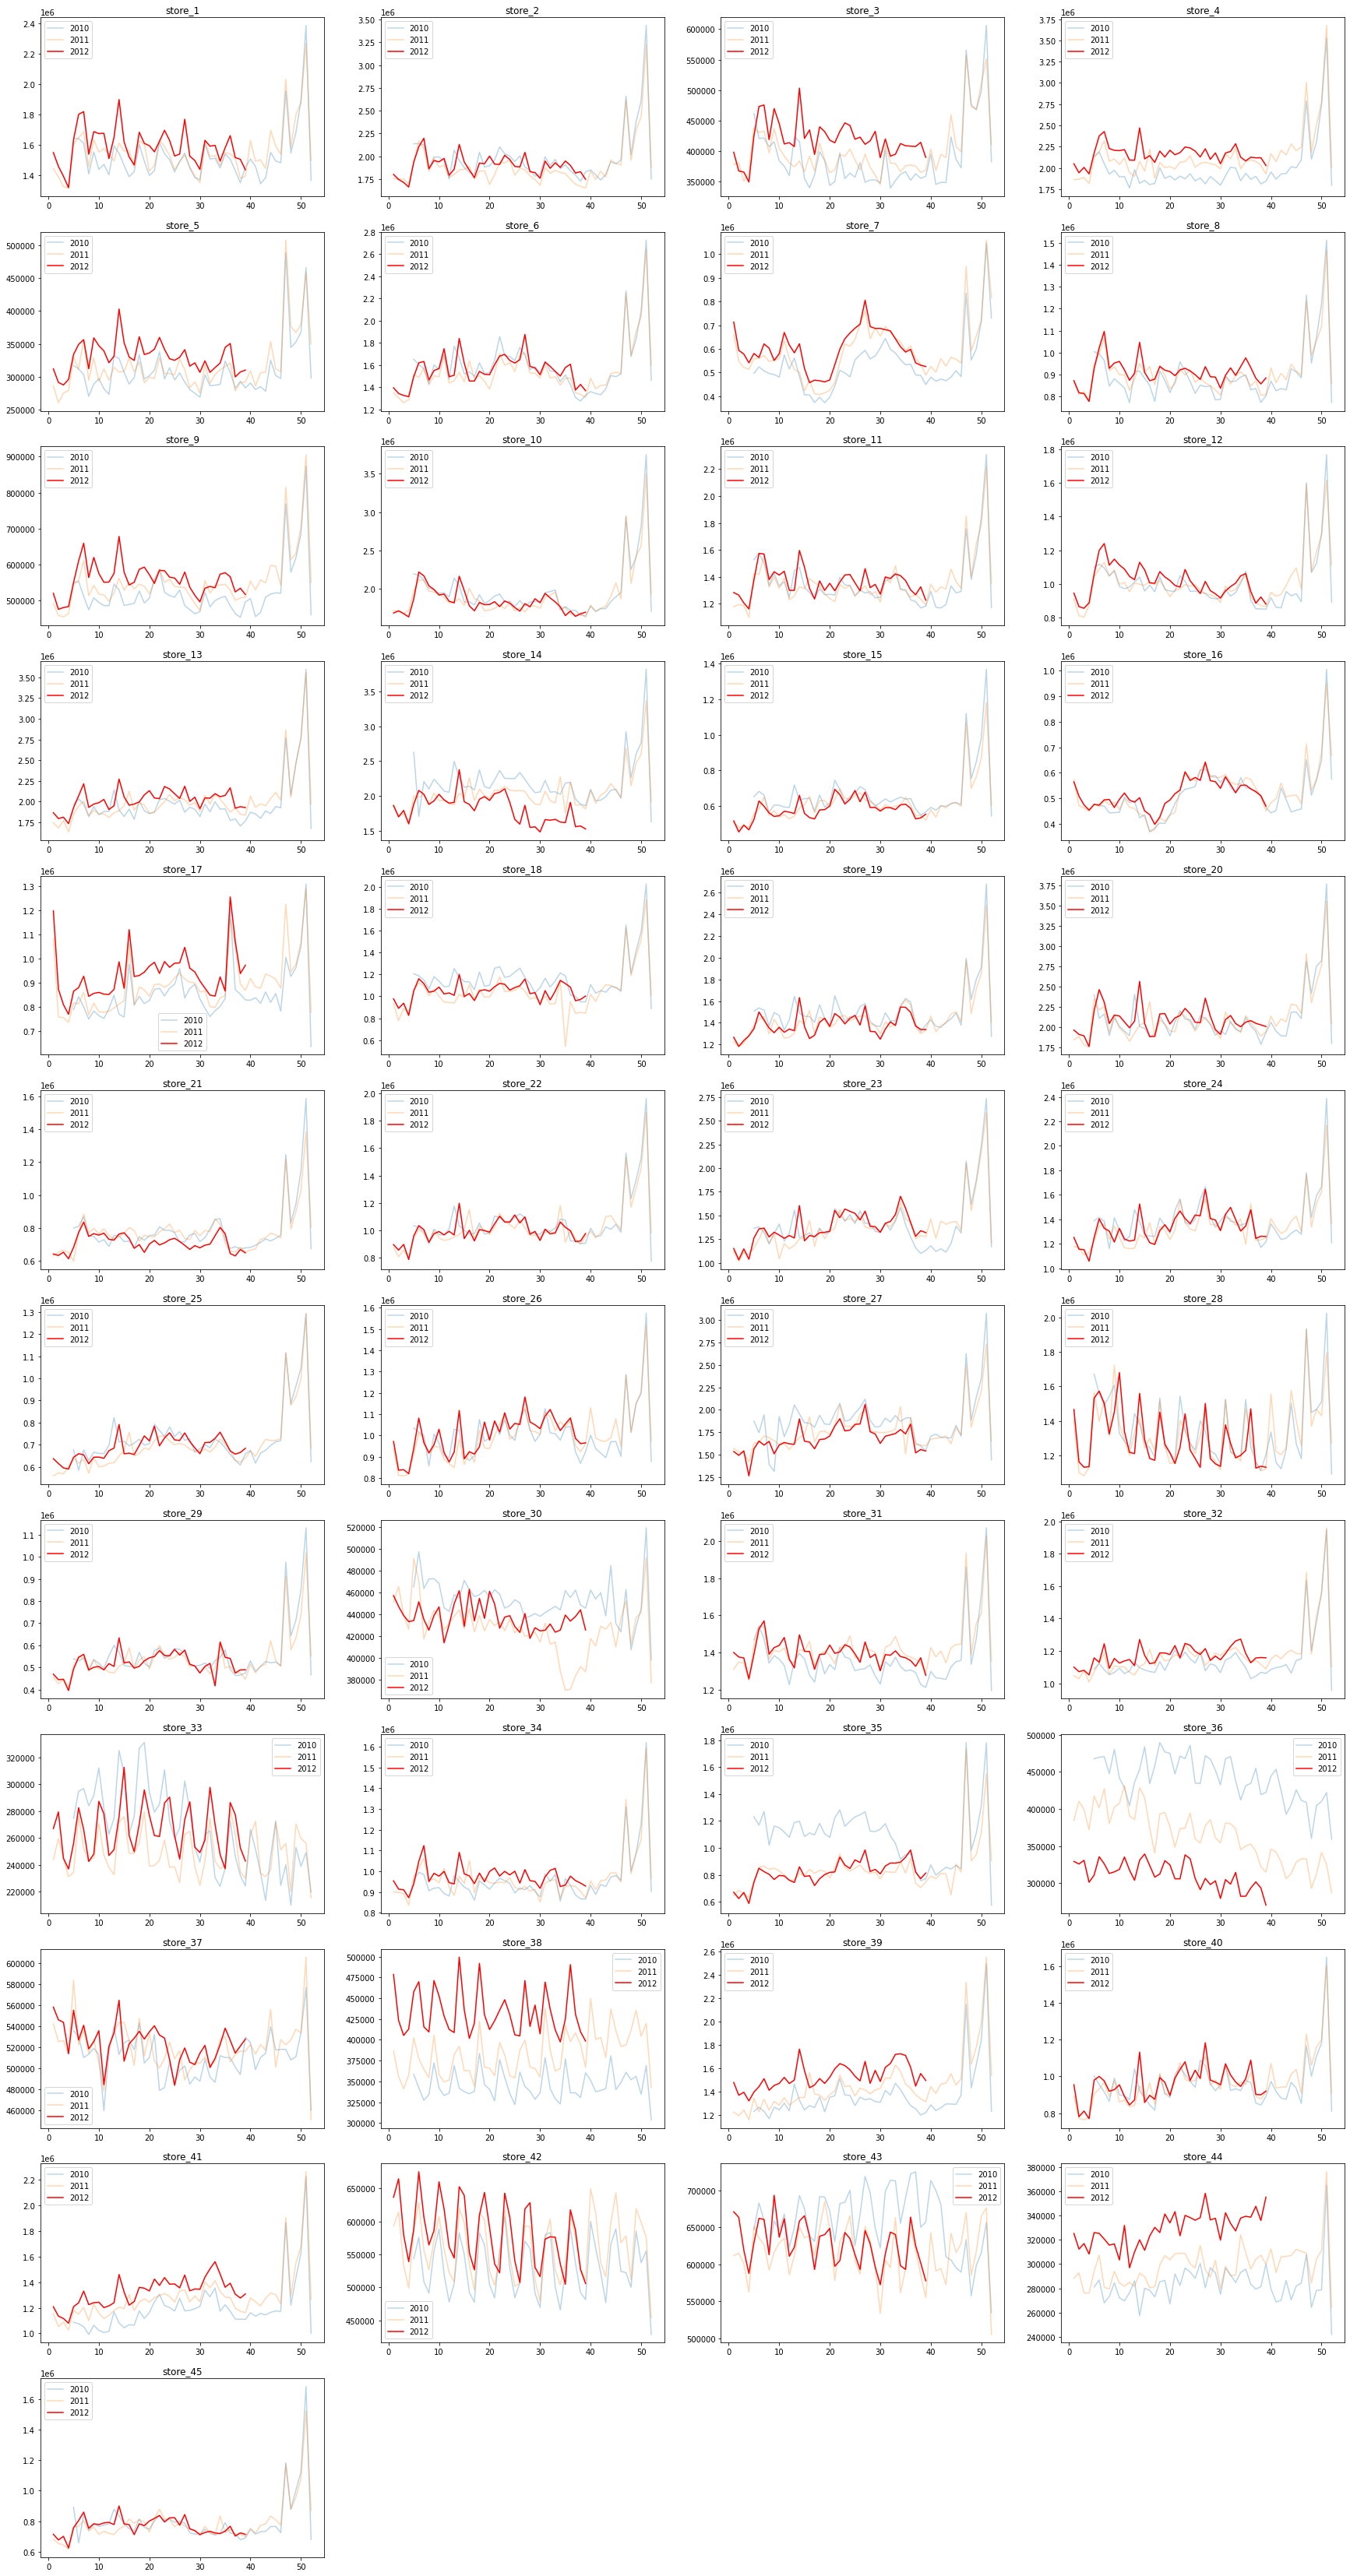

In [6]:
fig = plt.figure(figsize=(30,60))

for store in range(1,max(trainset.Store)+1):
    storeset = trainset[trainset.Store==store]
    storeset_2010 = storeset[storeset.Year==2010]
    storeset_2011 = storeset[storeset.Year==2011]
    storeset_2012 = storeset[storeset.Year==2012]
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.legend()
    
plt.show()

- 지점 별로 매출액 추이의 양상이 다르게 나타남
- 예측의 타겟이 되는 2012년도의 매출액의 주별 변화 추이가 2010년도에 더 비슷한 경우도 있고 2011년도에 더 비슷한 경우도 있음.

<br>

### 기본 전략

- 지점별로 예측 모델을 생성하자.
- 기준 연도(2010 또는 2011)와 2012년도 데이터를 이용하자.
- 기준 연도가 아닌 연도의 데이터는 과감하게 제외
- 2010, 2011 각각의 연도는 ~9월까지의 데이터, 2012년도는 8월까지의 데이터를 이용하여 학습하고 2012년도의 9월 데이터를 더 잘 예측하는 연도를 선택하자.

- 선택한 기준연도에 대해 ~10월까지의 데이터, 2012년도는 9월까지의 데이터를 이용하여 학습하고 최종적으로 2012년도 10월의 데이터를 예측해보자.

In [7]:
from sklearn.metrics import mean_squared_error

def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5

In [8]:
models = []

# 날짜 관련된 거만 했을 때 좀 더 좋게 나오는 거 같음
features = ['Store', 'NumberHoliday', 'Week', 'Day', 'Month', 'Year']

# 학습을 위한 하이퍼파라미터 설정
model_params = {
    "n_estimators": 60,
    "min_child_weight": 3,
    "max_depth": 6
}

for store in range(1,max(trainset.Store)+1):
    train_store = trainset[trainset.Store==store]
    
    # 2010, 2011, 2012 년도 별로 데이터 분리
    # 2012-09에 대해 예측하려고 하기 때문에 2012년도는 9월을 포함하지 않음
    train_store_2010 = train_store[(train_store.Year==2010) & (train_store.Month<=9)]
    train_store_2011 = train_store[(train_store.Year==2011) & (train_store.Month<=9)]
    train_store_2012 = train_store[(train_store.Year==2012) & (train_store.Month<9)]
    
    # 2011, 2010 년도를 제외한 데이터 생성
    train_store_2010_2012 = pd.concat([train_store_2010, train_store_2012])
    train_store_2011_2012 = pd.concat([train_store_2011, train_store_2012])
    
    # 각각의 모델 학습
    model_2010_2012 = xgboost.XGBRegressor(**model_params)
    model_2010_2012.fit(train_store_2010_2012[features],
                        train_store_2010_2012.Weekly_Sales)
    
    model_2011_2012 = xgboost.XGBRegressor(**model_params)
    model_2011_2012.fit(train_store_2011_2012[features],
                        train_store_2011_2012.Weekly_Sales)
    
    # 2012년도 9월에 대해서 예측
    x_test = train_store[(train_store.Year==2012) & (train_store.Month==9)]
    pred_2010_2012 = model_2010_2012.predict(x_test[features])
    pred_2011_2012 = model_2011_2012.predict(x_test[features])
    
    # 예측 결과 평가
    rmse_2010_2012 = RMSE(pred_2010_2012, x_test.Weekly_Sales)
    rmse_2011_2012 = RMSE(pred_2011_2012, x_test.Weekly_Sales)

    
    # 오차가 더 적은 연도를 선택
    similar_year = 2010
    if rmse_2010_2012 > rmse_2011_2012:
        similar_year = 2011

    print(f"{store:02}", similar_year, rmse_2010_2012, rmse_2011_2012)
    
    # 전체 데이터로 학습
    train_store_target = pd.concat([
        train_store[(train_store.Year==similar_year) & (train_store.Month<=10)],
        train_store[(train_store.Year==2012)]
    ])

    model = xgboost.XGBRegressor(**model_params)
    model.fit(train_store_target[features], train_store_target.Weekly_Sales)
        
    models.append(model)


[03:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
01 2011 59009.28790438577 43527.856196706074
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
02 2010 45903.933506835536 55462.57486148014
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:12] WARNING: /

In [9]:
pred = []
for store in range(1, max(trainset.Store)+1):
    test_store = testset[testset.Store==store]
    
    y = models[store-1].predict(test_store[features])
    pred += y.tolist()

In [10]:
test_pred = testset.copy()
test_pred["Weekly_Sales"] = pred

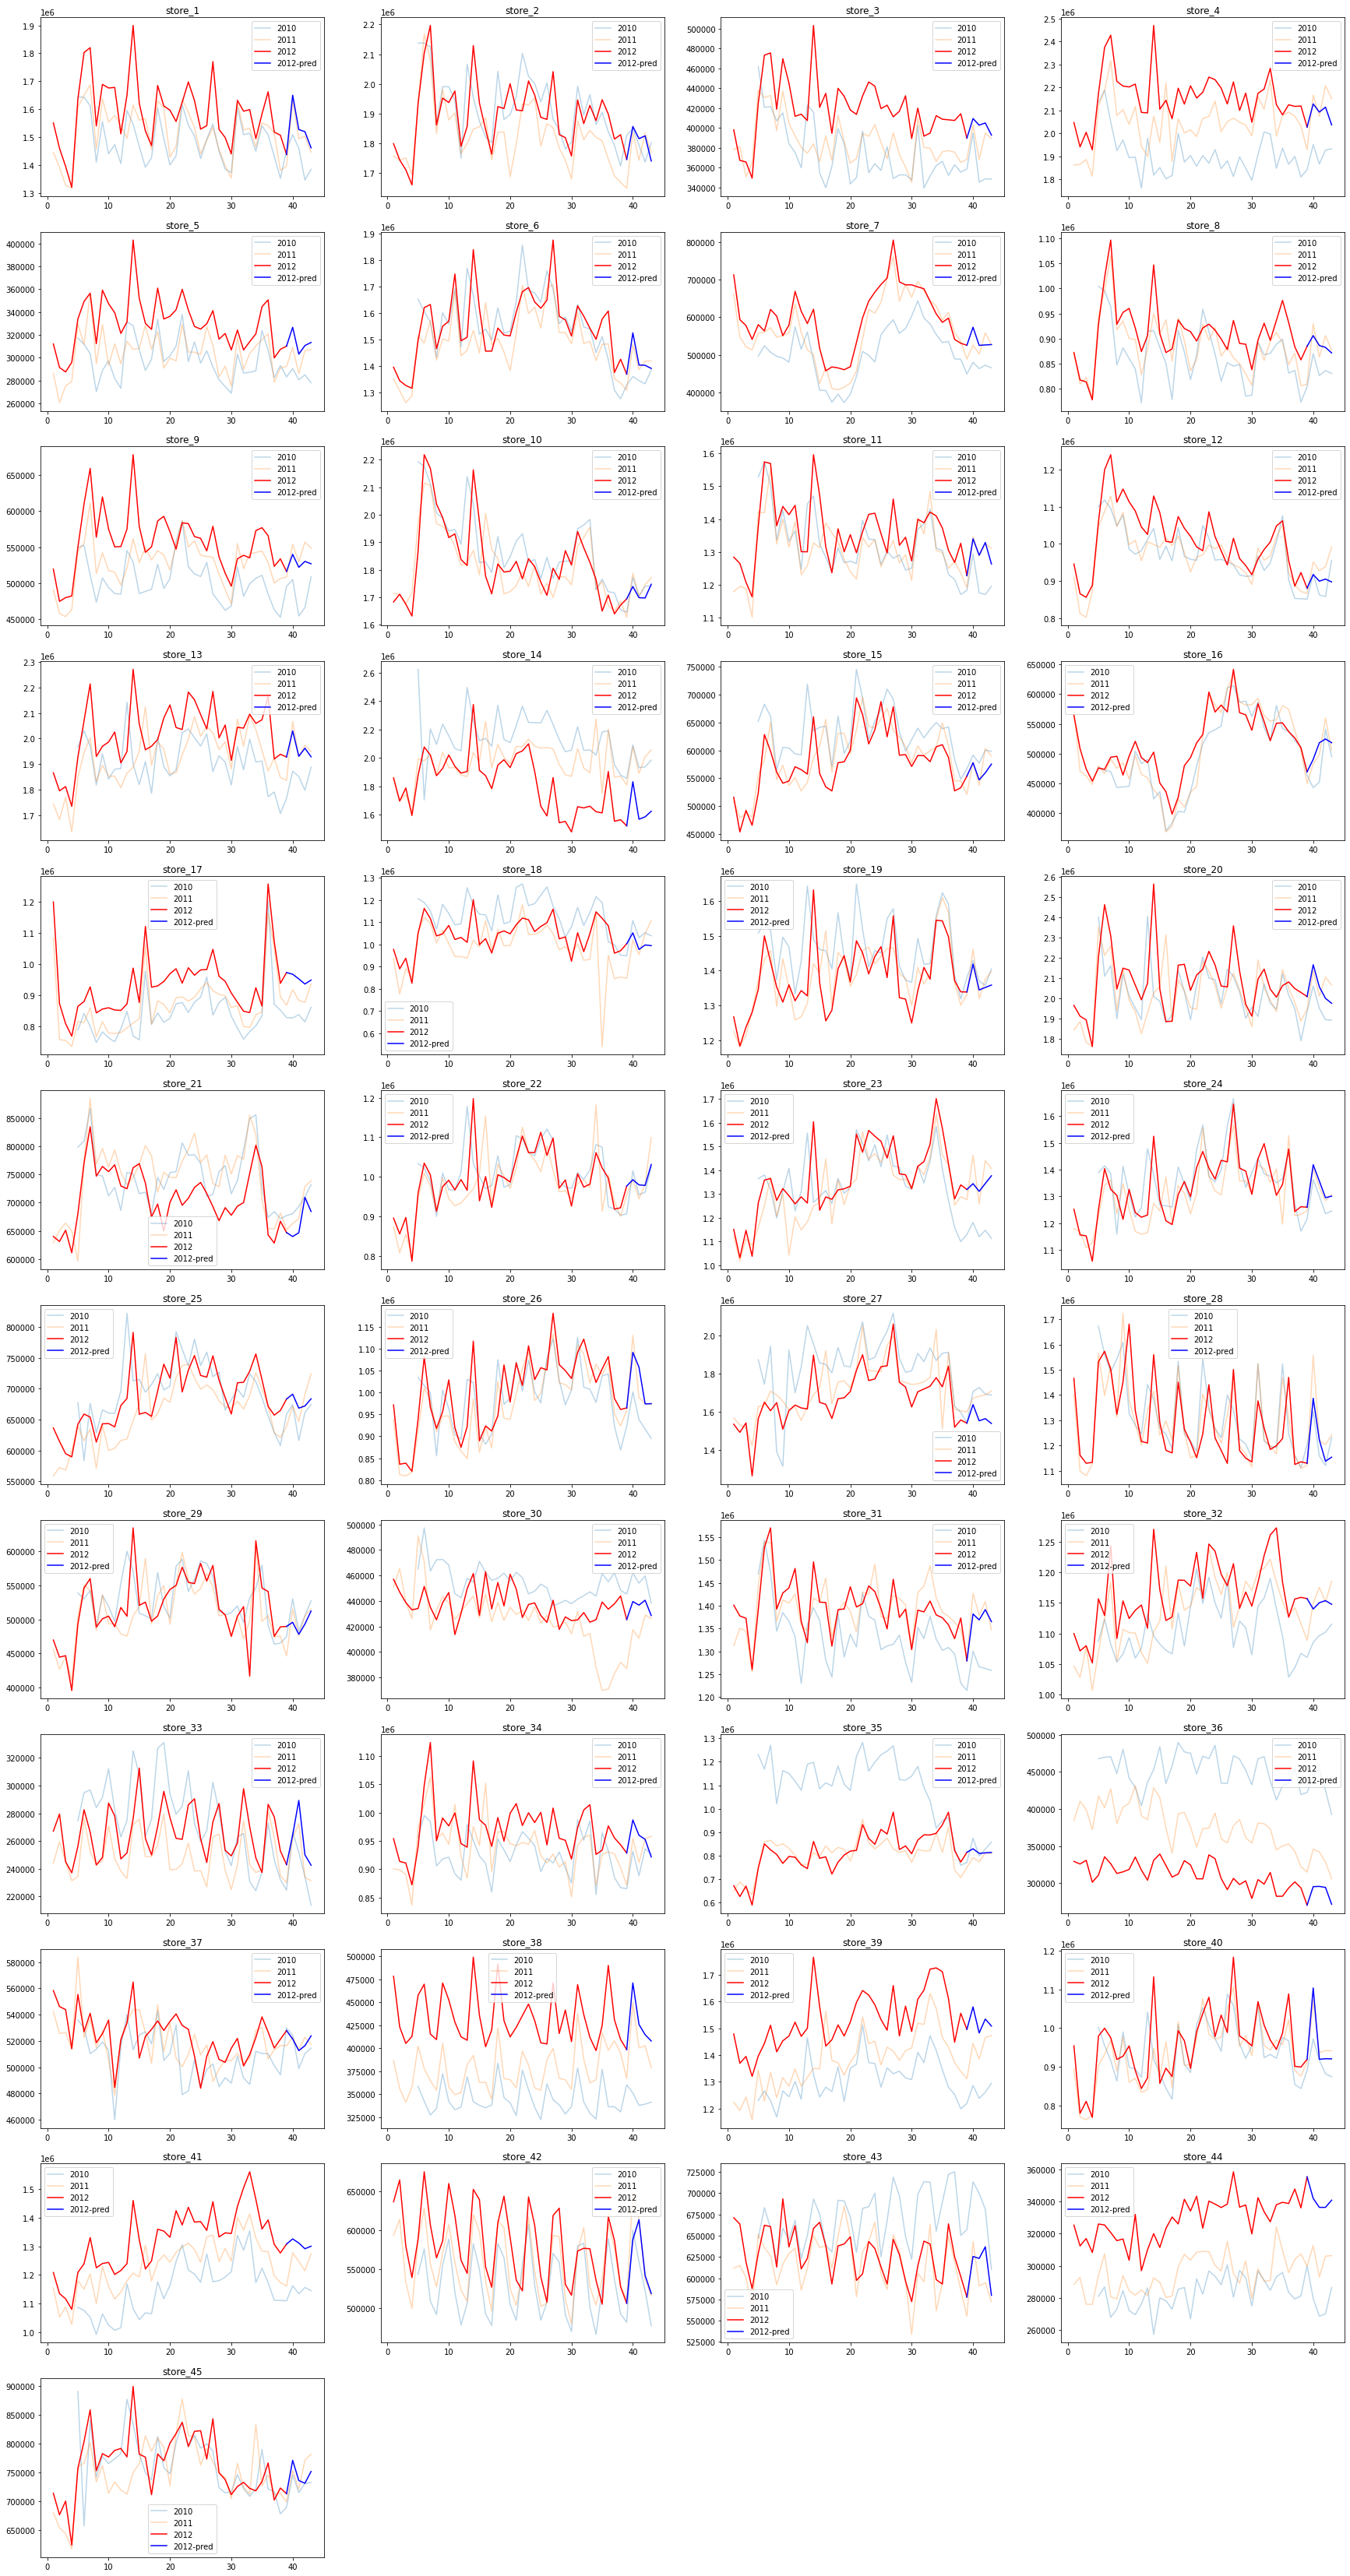

In [11]:
fig = plt.figure(figsize=(30,60))

for store in range(1,max(trainset.Store)+1):
    storeset = trainset[trainset.Store==store]
    storeset_2010 = storeset[(storeset.Year==2010) & (storeset.Month<=10)]
    storeset_2011 = storeset[(storeset.Year==2011) & (storeset.Month<=10)]
    storeset_2012 = storeset[(storeset.Year==2012) & (storeset.Month<=10)]
    
    test_pred_store = test_pred[test_pred.Store==store]
    
    # 그래프의 연속성을 위해 예측한 데이터의 전 주의 데이터도 넣어준다.
    test_pred_store = pd.concat([storeset_2012.iloc[-1:], test_pred_store])
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset_2010.Week, storeset_2010.Weekly_Sales, label="2010", alpha=0.3)
    ax.plot(storeset_2011.Week, storeset_2011.Weekly_Sales, label="2011", alpha=0.3)
    ax.plot(storeset_2012.Week, storeset_2012.Weekly_Sales, label="2012", color='r')
    ax.plot(test_pred_store.Week, test_pred_store.Weekly_Sales, label="2012-pred", color='b')
    ax.legend()
    
plt.show()

In [12]:
sample_submission["Weekly_Sales"] = test_pred.Weekly_Sales
sample_submission.to_csv('submission.csv',index = False)
sample_submission

,id,Weekly_Sales
0,1,1.649531e+06
1,2,1.526568e+06
2,3,1.518771e+06
3,4,1.460965e+06
4,5,1.857202e+06
...,...,...
175,176,3.408244e+05
176,177,7.712501e+05
177,178,7.361301e+05
178,179,7.313931e+05
